In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler

### Описание датасета

**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер район  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры

### Загрузка данных

In [82]:
test = pd.read_csv("test.csv")
test.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [83]:
train = pd.read_csv("train.csv")
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [84]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [85]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


## Обзор данных

### Целевая переменная -  **Цена квартиры (Price)**

In [86]:
train['Price'].describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

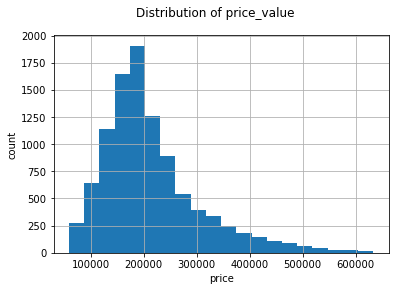

In [87]:
train['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('price')

plt.suptitle('Distribution of price_value')
plt.show()

Согласно графику целевая переменна имеет нормальное распределение без видимых выбросов

### Переменные признаки

In [88]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [90]:
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Согласно полученной информации в датасетее переменные LifeSquare, Healthcare_1 имеет пропуски.  
Переменные Ecology_2, Ecology_3, Shops_2 категориальные.

Рассмотрим далее каждую перемнную более детально.


### DistrictId - идентификатор района

In [91]:
train['DistrictId'].describe()

count    10000.000000
mean        50.400800
std         43.587592
min          0.000000
25%         20.000000
50%         36.000000
75%         75.000000
max        209.000000
Name: DistrictId, dtype: float64

Переменная несет в себе категириальную нагрузку, для удобства преобразуем ее в строковый тип

In [92]:
train['DistrictId'] = train['DistrictId'].astype(str)

Посмотрим распределение квартир в районах

In [93]:
district = train['DistrictId'].value_counts()
district

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
117      1
196      1
207      1
199      1
Name: DistrictId, Length: 205, dtype: int64

Создадим новую переменную, которая описывает количество предложений продажи квартир для каждого района

In [94]:
district_count = dict(train['DistrictId'].value_counts()) # создадим словарь {номер района: количество предложений}

In [95]:
train['DistrictId_count'] = train['DistrictId'].apply(lambda x: district_count[x]) #добавим новую переменную к датасету

In [96]:
train.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.93750,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.43750,87
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.90625,174


In [98]:
check = pd. pivot_table(train, index = ['DistrictId_count'], values = ['Price'], aggfunc = 'mean')
check.head(5)

,Price
DistrictId_count,
1,337755.46875
2,348211.68750
3,327216.37500
4,295583.87500
5,301932.81250


<function matplotlib.pyplot.show(close=None, block=None)>

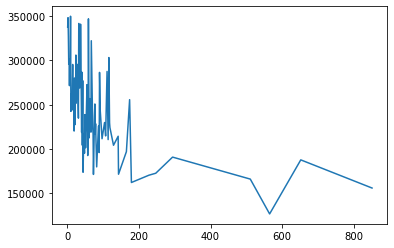

In [99]:
plt.plot(check.index,check['Price'])
plt.show


Введем новую бинарную переменную характеризующую район (густонаселенный 1  или элитный 0)

In [100]:
train['DistrictType'] = (train['DistrictId_count'] > 100).astype(int)

In [101]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,DistrictType
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.937500,22,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.437500,87,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.906250,174,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.234375,179,1
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531250,97,0


## Rooms - количество комнат

In [102]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [103]:
check = pd. pivot_table(train, index = ['Rooms'], values = ['Price'], aggfunc = 'mean')
check

,Price
Rooms,
0.0,200435.890625
1.0,159850.796875
2.0,215256.312500
3.0,289337.968750
4.0,383251.093750
5.0,410431.593750
6.0,229661.968750
10.0,244797.281250
19.0,78364.617188


Неправдоподобными значениями по количеству комнат 0, 10, 19. По средним ценам они близки к 2-х, 6-ти и 1-комнатным квартирам соответственно. Так же видим, что средняя стоимость 6-ти комнатных квартир существенно отличается от цены 5-ти комнатных в меньшую сторону, что очень маловероятна. И по-скольку она близка к стоимости 3-х комнатных, добавим их туда

In [104]:
train.loc[train['Rooms'].isin([0, 6]), 'Rooms'] = 2
train.loc[train['Rooms'].isin([10]), 'Rooms'] = 6
train.loc[train['Rooms'].isin([19]), 'Rooms'] = 1

In [105]:
train['Rooms'].value_counts()

2.0    3889
1.0    3706
3.0    2235
4.0     150
5.0      18
6.0       2
Name: Rooms, dtype: int64

## Square, LifeSquare, KitchenSquare - общая, жилая площадь и площадь кухни

In [106]:
train['LifeSquare'].describe()

count    7887.000000
mean       37.199596
std        86.241112
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

Согласно нормам минимальная жилая площадь в:
    - 1 - комнатной кв-ре - 14 кв м
    - 2 - комнатной кв-ре - 16 кв м
    - > 3 - комнатной кв-ре - 18 кв м   

In [107]:
train.loc[train['LifeSquare']<18 , 'LifeSquare'] = 18

In [108]:
train['LifeSquare'].median()

32.7812614440918

максимальная площадь кваритиры явна завышена заменим еще медианой

In [109]:
train.loc[train['LifeSquare'] >400, 'LifeSquare'] = train['LifeSquare'].median()

In [110]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare']= train['LifeSquare'].median()

In [111]:
train['LifeSquare'].describe()

count    10000.000000
mean        35.719269
std         15.530901
min         18.000000
25%         25.527400
50%         32.781261
75%         41.415442
max        263.542023
Name: LifeSquare, dtype: float64

In [112]:
train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [113]:
train['KitchenSquare'].unique().astype(int)

array([   6,    8,    0,    9,    7,   12,    1,    5,   11,   10,   15,
         13,   72,    4,   17,   19,   16,   48,   22,   14, 2014,   37,
         66,   78,    3,   53,   43,   20,   26,   23,   96,  112,    2,
         30,   36,   42,   63,   60,   41,   18,   31,   73,   58,   35,
         32,   29,   40,   62,   51,   75,   84,   25,   21,   54, 1970,
         27,   39,  123])

Явные выбросы 1970 и 2014 заменим их средним значением

In [114]:
train.loc[train['KitchenSquare']==2014, 'KitchenSquare']=train['KitchenSquare'].mean()
train.loc[train['KitchenSquare']==1970, 'KitchenSquare']=train['KitchenSquare'].mean()

In [115]:
train['KitchenSquare'].describe()

count    10000.000000
mean         5.876135
std          5.174088
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max        123.000000
Name: KitchenSquare, dtype: float64

Проверим есть ли значения общей площади меньше, чем сумма жилой и кухни

In [116]:
sq_check = train.loc[train['Square'] < train['KitchenSquare']+ train['LifeSquare']].index  #проверим если значения площади кухни больше площади квартир
sq_check

Int64Index([   3,   28,   44,   48,   52,   69,  123,  129,  136,  145,
            ...
            9878, 9884, 9889, 9895, 9897, 9902, 9910, 9918, 9961, 9974],
           dtype='int64', length=925)

заменим эти значения на сумму площадей кухни и жилой площади

In [117]:
train.loc[sq_check, 'Square'] = train.loc[sq_check, 'LifeSquare']+train.loc[sq_check,'KitchenSquare']

In [118]:
train['Square'].describe()

count    10000.000000
mean        56.937130
std         21.615894
min         18.000000
25%         42.160932
50%         52.972170
75%         66.382925
max        641.065186
Name: Square, dtype: float64

In [121]:
check = pd. pivot_table(train, index = ['Square'], values = ['Price'], aggfunc = 'mean')
check

,Price
Square,
18.000000,98460.656250
19.000000,292144.437500
19.927423,102395.789062
20.000000,112411.218750
20.606762,108379.890625
...,...
268.542023,141780.234375
275.645294,455264.875000
409.425171,90470.429688


Видим, что квартиры площадью более 275 кв м имеет цену меньше чем квартиры площадью 275 кв м, заменим меданой

In [122]:
train.loc[train['Square']==409.425171, 'Square']=train['Square'].mean()
train.loc[train['Square']==604.705994, 'Square']=train['Square'].mean()
train.loc[train['Square']==641.065186, 'Square']=train['Square'].mean()

In [123]:
train['Square'].describe()

count    10000.000000
mean        56.788681
std         19.765265
min         18.000000
25%         42.160932
50%         52.972170
75%         66.358042
max        275.645294
Name: Square, dtype: float64

C:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение переменной Square')

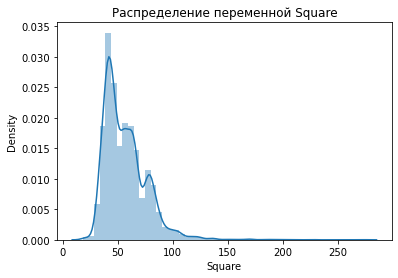

In [124]:
sns.distplot(train['Square'])
plt.title('Распределение переменной Square')

## HouseFloor - этажность дома

In [125]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

заменим нулевое значение этажности дома на минимальное, а 99 и 117 на максимальное зн-ие - 48

In [126]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = 1
train.loc[train['HouseFloor'] == 99, 'HouseFloor'] = 48
train.loc[train['HouseFloor'] == 117, 'HouseFloor'] = 48

Добавим переменную, характеризующую тип застройки House_Type:
    1 - одноэтажки
    2 - двуэтакжки
    3 - трехэтажки
    4 - 4хэтажки
    5 - пятиэтажки
    6 - многоэтажки

In [127]:
def house(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x == 4:
        return 4
    elif x == 5:
        return 5    
    elif x > 5:
        return 6
train['House_Type'] = train['HouseFloor'].apply( lambda x: house(x))

In [128]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,DistrictType,House_Type
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.937500,22,0,6
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.437500,87,0,6
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.906250,174,1,6
3,5809,58,2.0,61.731510,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.234375,179,1,6
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531250,97,0,6


## Floor -  этаж, на котором расположена квартира

In [129]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

проверим есть ли в датасети квартиры расположенные на этаже большем этажности дома

In [130]:
floor_check = train.loc[train['HouseFloor'] < train['Floor']].index  
floor_check

Int64Index([   7,   14,   16,   21,   23,   26,   35,   39,   44,   51,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1818)

заменим для данных квартир этаж расположения на максимальный этаж в доме

In [131]:
train.loc[floor_check, 'Floor'] = train.loc[floor_check, 'HouseFloor']

добавим новую переменную, характеризующую расположение квартиры(первый (1) или последний этаж(0))

In [132]:
train['1st_last_flor'] = train['HouseFloor'] - train['Floor']
train['1st_last_flor'] = train['1st_last_flor'].apply(lambda x: 0 if x > 0 else 1)
train.loc[train['Floor'] == 1, '1st_last_flor'] = 1

In [133]:
train.loc[train['1st_last_flor'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,DistrictType,House_Type,1st_last_flor
7,11993,74,2.0,80.312927,32.781261,0.0,1.0,1.0,1977,0.075779,...,3,NaN,0,2,B,221244.156250,114,1,1,1
11,12427,31,3.0,68.808861,45.736904,7.0,1.0,8.0,1959,0.000000,...,2,NaN,0,4,B,165534.546875,55,0,6,1
14,10953,27,1.0,53.769096,52.408028,1.0,4.0,4.0,1977,0.072158,...,1,NaN,0,0,A,140647.562500,851,1,4,1
16,2119,27,2.0,49.360649,31.993963,5.0,5.0,5.0,1983,0.051815,...,0,NaN,0,0,B,117000.382812,851,1,5,1
21,11935,27,2.0,64.711838,32.781261,1.0,1.0,1.0,1977,0.211401,...,0,NaN,0,1,B,127200.023438,851,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,11553,3,3.0,101.622795,51.628780,12.0,17.0,17.0,2000,0.265089,...,0,1937.0,3,2,B,212883.500000,82,0,6,1
9994,4158,23,2.0,64.864197,32.781261,1.0,17.0,17.0,1977,0.075779,...,3,NaN,0,2,B,171323.515625,565,1,6,1
9995,77,32,2.0,50.401787,30.476204,5.0,5.0,5.0,1968,0.135650,...,6,350.0,3,11,B,196684.312500,34,0,5,1
9996,6159,18,1.0,41.521545,20.539215,9.0,13.0,13.0,2000,0.000000,...,0,NaN,0,5,A,189050.296875,51,0,6,1


## HouseYear - год постройки дома

In [134]:
train['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Заменим ошибочные данные года постройки дома

In [135]:
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [136]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [137]:
train['HouseYear'].describe()

count    10000.000000
mean      1984.865700
std         18.411517
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

Введем новую переменную, характеризующую новостройка или нет

In [138]:
train['Hous_Type'] = train['HouseYear'].apply(lambda x: 0 if x < 2017 else 1)

In [139]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictId_count,DistrictType,House_Type,1st_last_flor,Hous_Type
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,NaN,0,11,B,184966.937500,22,0,6,0,0
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,240.0,1,16,B,300009.437500,87,0,6,0,0
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,229.0,1,3,B,220925.906250,174,1,6,0,0
3,5809,58,2.0,61.731510,52.731510,9.0,8.0,17.0,1977,0.437885,...,1084.0,0,5,B,175616.234375,179,1,6,0,0
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531250,97,0,6,0,0


## Healthcare_1


Заменим пропуски Healthcare_1 медианой этой переменной

In [140]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

## Ecology_2, Ecology_3, Shops_2

Строковые переменные имеющие значения либо А, либо В. Заменим их бинарными значениями 0, 1

In [141]:
train['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [142]:
train['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [143]:
train['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [144]:
train['Ecology_2_new'] = 0
train.loc[train['Ecology_2'] == 'B', 'Ecology_2_new'] = 1

In [145]:
train['Ecology_3_new'] = 0
train.loc[train['Ecology_3'] == 'B', 'Ecology_3_new'] = 1

In [146]:
train['Shops_2_new'] = 0
train.loc[train['Shops_2'] == 'B', 'Shops_2_new'] = 1

## MedPriceByDistrict, MedPriceFloors

Введем новую переменную MedPriceByDistrict характеризующую среднию цену для квартир в данном районе в зависимости от комнатности и MedPriceFloors и среднюю цену в зависимости от расположения квартиры на этаже

In [148]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146574.015625
4,1,2.0,202706.093750


In [149]:
med_price_by_floors = train.groupby(['1st_last_flor'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceFloors'})

med_price_by_floors.head()

,1st_last_flor,MedPriceFloors
0,0,194261.281250
1,1,187595.515625


In [150]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,DistrictId_count,DistrictType,House_Type,1st_last_flor,Hous_Type,Ecology_2_new,Ecology_3_new,Shops_2_new,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,184966.937500,22,0,6,0,0,1,1,1,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,300009.437500,87,0,6,0,0,1,1,1,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,220925.906250,174,1,6,0,0,1,1,1,263206.218750
3,5809,58,2.0,61.731510,52.731510,9.0,8.0,17.0,1977,0.437885,...,175616.234375,179,1,6,0,0,1,1,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,150226.531250,97,0,6,0,0,1,1,1,158539.062500


In [151]:
train = train.merge(med_price_by_floors, on=['1st_last_flor'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictId_count,DistrictType,House_Type,1st_last_flor,Hous_Type,Ecology_2_new,Ecology_3_new,Shops_2_new,MedPriceByDistrict,MedPriceFloors
0,14038,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,...,22,0,6,0,0,1,1,1,207786.125000,194261.28125
1,15053,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,...,87,0,6,0,0,1,1,1,300009.437500,194261.28125
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,...,174,1,6,0,0,1,1,1,263206.218750,194261.28125
3,5809,58,2.0,61.731510,52.731510,9.0,8.0,17.0,1977,0.437885,...,179,1,6,0,0,1,1,1,166809.671875,194261.28125
4,10783,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,...,97,0,6,0,0,1,1,1,158539.062500,194261.28125


In [152]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictId_count',
 'DistrictType',
 'House_Type',
 '1st_last_flor',
 'Hous_Type',
 'Ecology_2_new',
 'Ecology_3_new',
 'Shops_2_new',
 'MedPriceByDistrict',
 'MedPriceFloors']

In [153]:
feature_names = ['MedPriceFloors','Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear', 'Ecology_1', 
                 'DistrictId_count','DistrictType','House_Type','1st_last_flor','Hous_Type','Ecology_2_new',
                 'Ecology_3_new','Shops_2_new','MedPriceByDistrict', 'MedPriceFloors']
target_name = 'Price'

Разобьем выборку на тренировочную и валидационную

In [154]:
X = train[feature_names]
y = train[target_name]

In [155]:
X

,MedPriceFloors,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,DistrictId_count,DistrictType,House_Type,1st_last_flor,Hous_Type,Ecology_2_new,Ecology_3_new,Shops_2_new,MedPriceByDistrict,MedPriceFloors
0,194261.281250,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,22,0,6,0,0,1,1,1,207786.125000,194261.281250
1,194261.281250,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,87,0,6,0,0,1,1,1,300009.437500,194261.281250
2,194261.281250,2.0,44.947952,29.197611,0.0,8.0,12.0,1968,0.049637,174,1,6,0,0,1,1,1,263206.218750,194261.281250
3,194261.281250,2.0,61.731510,52.731510,9.0,8.0,17.0,1977,0.437885,179,1,6,0,0,1,1,1,166809.671875,194261.281250
4,194261.281250,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,97,0,6,0,0,1,1,1,158539.062500,194261.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,187595.515625,2.0,50.401787,30.476204,5.0,5.0,5.0,1968,0.135650,34,0,5,1,0,1,1,1,233599.109375,187595.515625
9996,187595.515625,1.0,41.521545,20.539215,9.0,13.0,13.0,2000,0.000000,51,0,6,1,0,1,1,0,171162.187500,187595.515625
9997,194261.281250,1.0,47.939007,32.781261,1.0,12.0,16.0,2015,0.072158,851,1,6,0,0,1,1,0,118327.093750,194261.281250
9998,187595.515625,2.0,43.602562,33.840149,8.0,1.0,5.0,1961,0.307467,66,0,5,1,0,1,0,1,187966.406250,187595.515625


In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=47
)

In [157]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=50, n_estimators=200,
                      random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=50, n_estimators=200,
                      random_state=42)

In [158]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.783
Test R2:	0.736


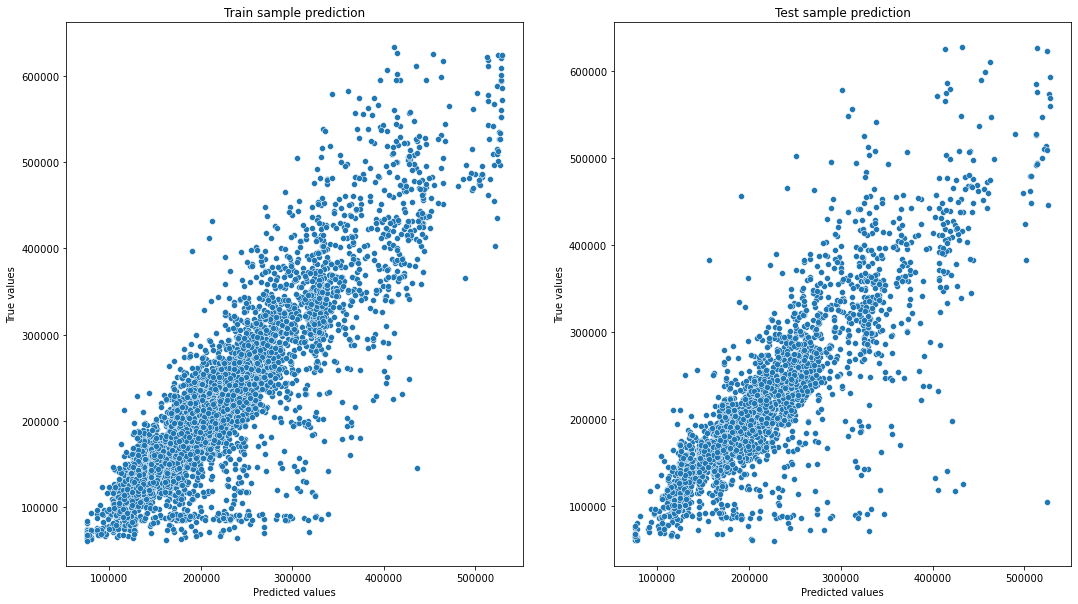

In [159]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)


Подберем оптимальные параметры с помощью Gridsearch

In [160]:
parametrs = { 'n_estimators': range (300, 500, 100),
              'max_depth': range (10,20, 5),
              'min_samples_leaf': range (10,20,5),
              'min_samples_split': range (50,100,50) }


In [161]:
grid = GridSearchCV(rf_model, parametrs, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=8, min_samples_split=50,
                                             n_estimators=200,
                                             random_state=42),
             param_grid={'max_depth': range(10, 20, 5),
                         'min_samples_leaf': range(10, 20, 5),
                         'min_samples_split': range(50, 100, 50),
                         'n_estimators': range(300, 500, 100)})

In [162]:
grid.best_estimator_

RandomForestRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42)

In [163]:
rf_model = RandomForestRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=50,
                      n_estimators=300, random_state=42)

Train R2:	0.787
Test R2:	0.745


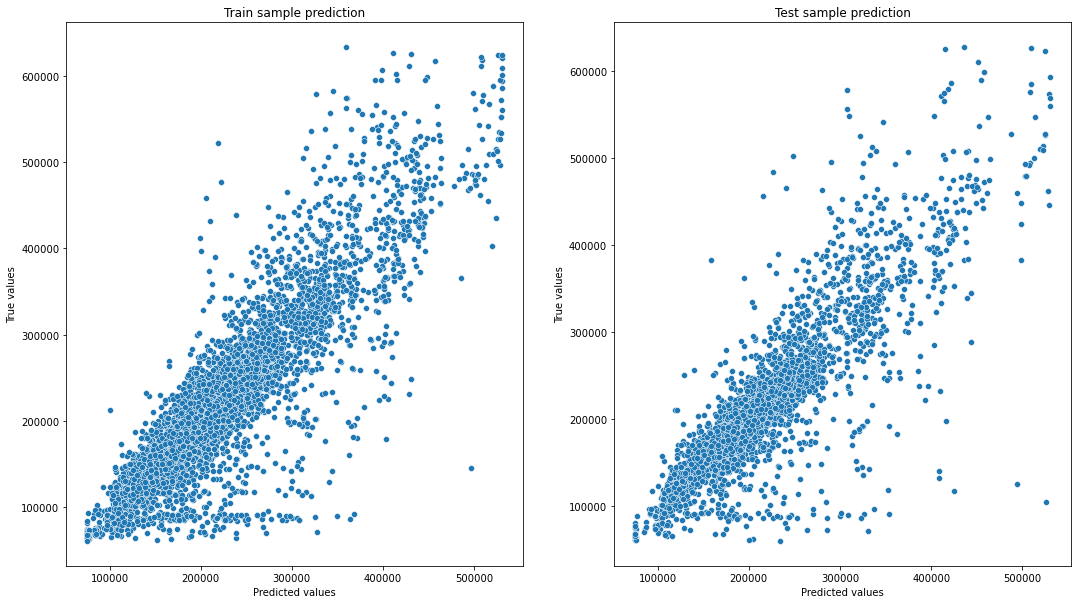

In [164]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)